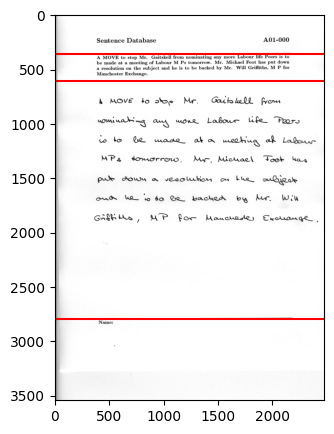

In [2]:
from statistics import linear_regression

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import os
from config import Config
from separate_page_sections import find_separators

image = "a01-000u.png"
image = imread(os.path.join(Config.Paths.train_images, image))
separators = find_separators(image)
handwritten_part = image[separators[1]:separators[2], :]

plt.figure(figsize=(10, 5))
plt.imshow(image, cmap='gray')
plt.axhline(separators[0], color='red')
plt.axhline(separators[1], color='red')
plt.axhline(separators[2], color='red')
plt.show()

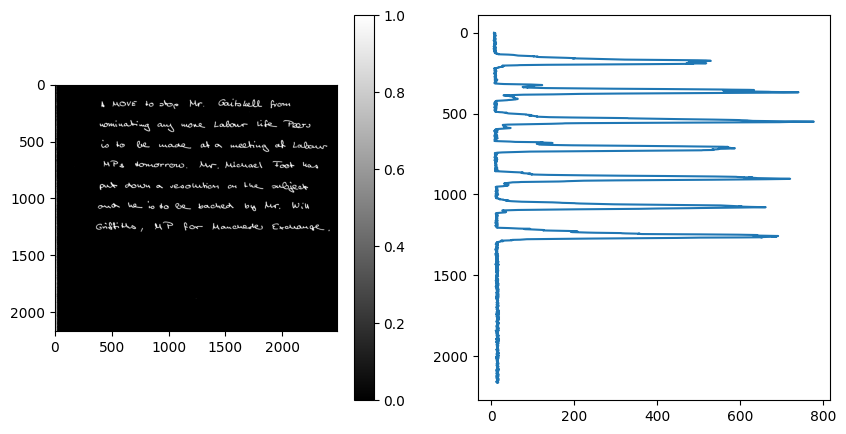

In [3]:
from skimage.filters import threshold_otsu

def binarize_image(image):
    im = image.copy()
    threshold = threshold_otsu(im)
    return (im < threshold).astype(np.uint)

def count_pixels_per_line(image):
    return np.sum(image == 1, axis=1)

handwritten_bin = binarize_image(handwritten_part[10:-10, :])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(handwritten_bin, cmap='gray')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(count_pixels_per_line(handwritten_bin.astype(np.uint)), range(handwritten_bin.shape[0]))
plt.gca().invert_yaxis()
plt.show()

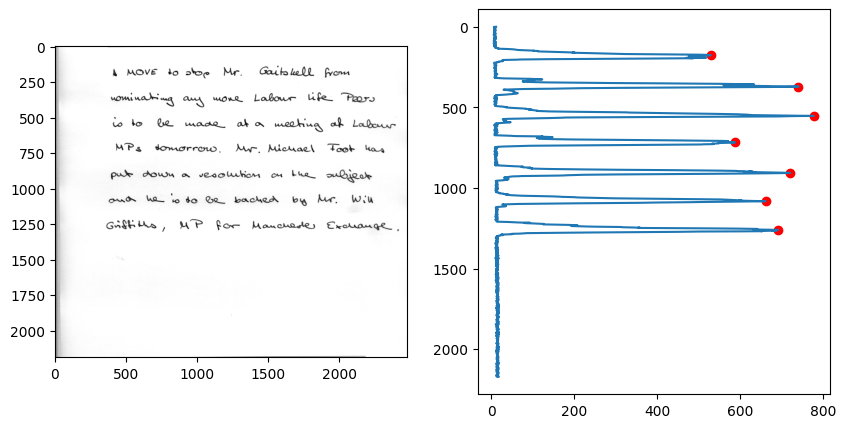

In [4]:
def find_lines_max(px_count_per_line, threshold=0.5):
    lines_indices = []
    count = px_count_per_line.copy()
    max_count = np.max(count)
    while np.max(count) >= threshold * max_count:   
        i = np.argmax(count)    # Find the index of the maximum value
        lines_indices.append(i)
        count[i] = 0
    return sorted(lines_indices)

def aggregate_close_lines(lines_indices, pixel_count_per_line, threshold=10):
    lines_positions = [[lines_indices[0]]]
    lines_indices = np.sort(lines_indices)
    for i in range(1, len(lines_indices)):
        if (lines_indices[i] - lines_positions[-1][-1]) < threshold:    # If the current line is close to the last line
                lines_positions[-1].append(lines_indices[i])            # Add it to the last line
        else:
            lines_positions.append([lines_indices[i]])                  # Otherwise, start a new line
    lines_positions = [(np.argmax([pixel_count_per_line[position] for position in line]) + line[0]) for line in lines_positions]    # Find the position of the line as the one with the most pixels
    return lines_positions

def find_possible_line_positions(image):
    image = image[7:-7, :]  # Remove the top and bottom 7 pixels because they are where the lines delimiting the text are, and they are not part of the text
    image_bin = binarize_image(image)
    pixels_per_line = count_pixels_per_line(image_bin)
    lines = find_lines_max(pixels_per_line)
    lines = aggregate_close_lines(lines, pixels_per_line)
    return lines, pixels_per_line

lines, pixels_per_line = find_possible_line_positions(handwritten_part)
    
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(handwritten_part, cmap='gray')
plt.subplot(1, 2, 2)
plt.plot(pixels_per_line, range(pixels_per_line.shape[0]))
plt.scatter([pixels_per_line[line] for line in lines], lines, color='red')
plt.gca().invert_yaxis()
plt.show()

6


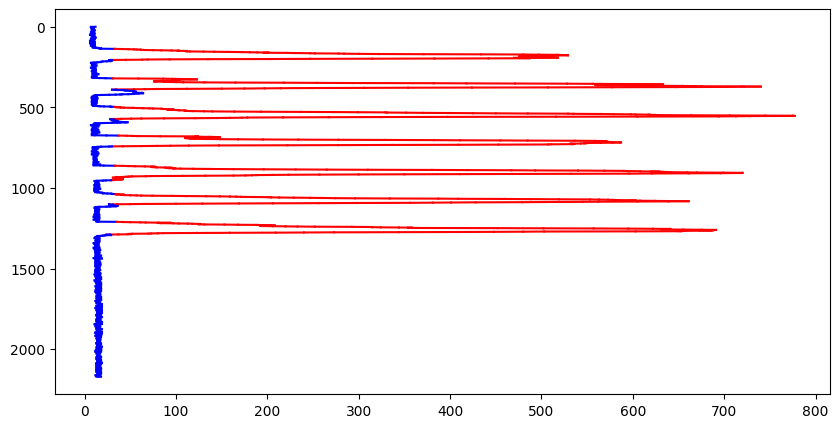

In [5]:
def find_peak_corresponding_to_line(peaks_positions, pixel_count_per_line, threshold=5):
    peaks = [[peak] for peak in peaks_positions]
    minimum = np.min(pixel_count_per_line)
    print(minimum)
    for peak in peaks:
        peak_position = peak[0]
        left_done = False
        right_done = False
        for i in range(1, len(pixel_count_per_line)):
            if left_done and right_done:
                break
            if peak_position - i >= 0 and pixel_count_per_line[peak_position - i] > threshold * minimum and not left_done:
                peak.insert(0, peak_position - i)
            else:
                left_done = True
            if peak_position + i < len(pixel_count_per_line) and pixel_count_per_line[peak_position + i] > threshold * minimum and not right_done:
                peak.append(peak_position + i)
            else:
                right_done = True
            
    return peaks

peaks = find_peak_corresponding_to_line(lines, pixels_per_line)

def plot_with_peaks(pixels_per_line, peaks):
    plt.figure(figsize=(10, 5))
    plt.gca().invert_yaxis()
    
    for i in range(len(pixels_per_line) - 1):
        color = 'red' if any(i in peak for peak in peaks) else 'blue'
        plt.plot(pixels_per_line[i:i+2], [i, i+1], color=color)
    
    plt.show()

# Call the function with your data
plot_with_peaks(pixels_per_line, peaks)

In [25]:
def find_lines(image):
    count = count_pixels_per_line(binarize_image(image))
    
    freq = [0] * (np.max(count) + 1)
    for line in count:
        freq[line] += 1
    print(np.argmax(freq))
        
    minimum = np.max([np.min(count), 8])
    lines = count > 2 * minimum    # Lines are where there are more than 3 times the minimum number of pixels
    filtered_lines = filter_lines(lines)
    filtered_lines = split_merged_lines(filtered_lines, count)
    return filtered_lines

def filter_lines(mask):
    line_boundaries = []
    in_line = False
    for i, value in enumerate(mask):
        if value and not in_line:
            in_line = True
            start = i
        elif not value and in_line:
            in_line = False
            end = i
            if end - start > 15:
                line_boundaries.append((start, end))
    if in_line:
        if len(mask) - start > 15:
            line_boundaries.append((start, len(mask)))
    return line_boundaries

def split_merged_lines(line_boundaries, pixel_count_per_line):
    print(line_boundaries)
    new_boundaries = []
    for start, end in line_boundaries:
        # Find the number of local minima in the window. If there are more than 2, split the line
        window_size = 40        # TODO: Magic number
        minima = []
        for i in range(start, end):
            left = max(start, i - window_size)
            right = min(end, i + window_size)
            if pixel_count_per_line[i] == np.min(pixel_count_per_line[left:right]):   # If the pixel count is the minimum in the window
                if not minima or (i - minima[-1] > window_size):    # 
                    minima.append(i)

        if len(minima) > 2:
            for i in range(1, len(minima)):
                new_boundaries.append((minima[i-1], minima[i]))
        else:
            new_boundaries.append((start, end))
    return new_boundaries

0
[(48, 132), (136, 234), (244, 329), (340, 434), (446, 531), (554, 855), (879, 1043)]


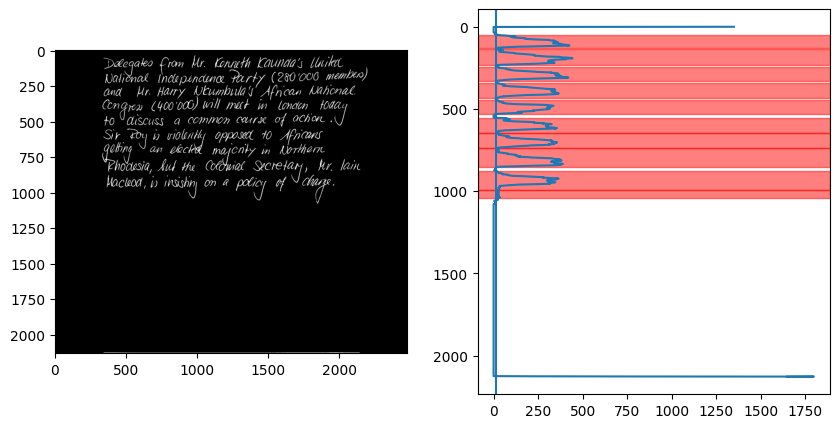

In [28]:
image = "a01-011x.png"
image = imread(os.path.join(Config.Paths.train_images, image))
separators = find_separators(image)
handwritten_part = image[separators[1]:separators[2], :]

line_boundaries = find_lines(handwritten_part)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(binarize_image(handwritten_part), cmap='gray')
plt.subplot(1, 2, 2)
px_per_line = count_pixels_per_line(binarize_image(handwritten_part))
plt.plot(px_per_line, range(px_per_line.shape[0]))
for start, end in line_boundaries:
    plt.axhspan(start, end, color='red', alpha=0.5)
plt.axvline(15)
plt.gca().invert_yaxis()
plt.show()

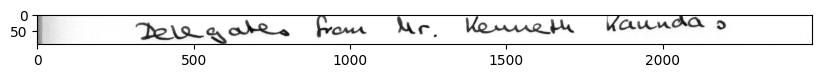

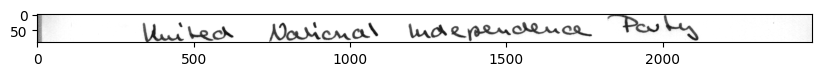

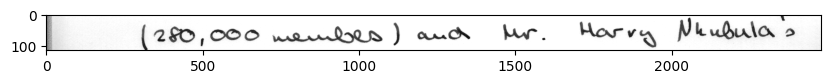

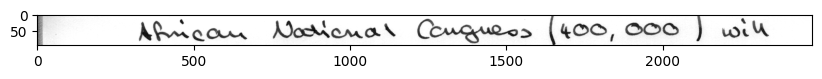

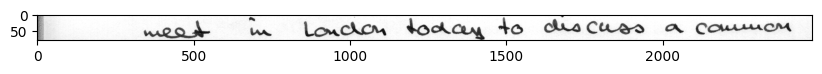

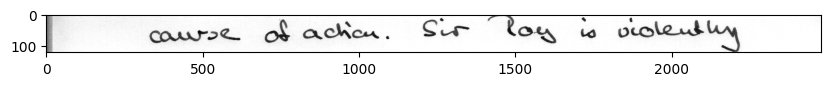

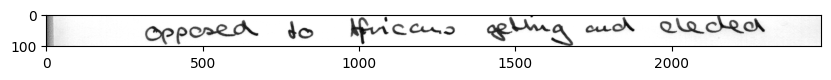

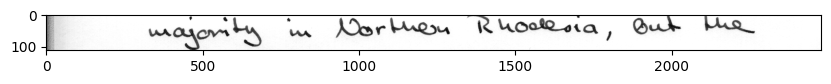

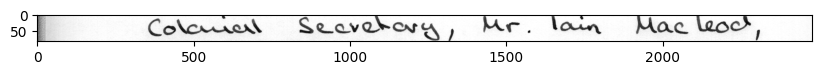

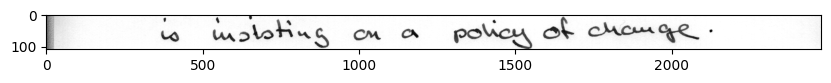

In [20]:
for start, end in line_boundaries:
    plt.figure(figsize=(10, 5))
    plt.imshow(handwritten_part[start:end, :], cmap='gray')
    plt.show()